# Assignment 2 -- Deep Learning PhD course

We first prepare the playground for this report and import some packages and detect if there is a CUDA device in the machine.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Here are two separate files which contain some useful functions for data loading

In [2]:
import data_handling as dh
import my_nn_pytorch as mnn
import my_plot_functions as mpf

# 1 Classification of hand-written digits using a Convolutional Neural Network

We first define the hyper parameters, which we are going to use in the following:

In [3]:
batch_size_train = 64         # batch size during training
batch_size_test = 1000       # batch size for the test data
lr_sgd = 1e-1                 # learning rate for Stochastic Gradient Descent (SGD)
nepochs = 1                  # number of epochs to run the training

The rational behind the choice of the parameters is the following:
1. ``batch_size_train``: we choose it small to avoid overfitting of the data even if it is computationally less efficient
2. ``batch_size_test``: we choose it large, since my GPU can handle it and I think that the evaluation should go faster if we run it all at once
3. ``lr_sgd``: I have observed that with this learning rate the training goes relatively fast and gives still good final accuracy

## 1.1 Fully connected neural network

We have constructed a 

In [4]:
import ex11_fc_pytorch as fcp
fname = fcp.params2fname(nepochs, lr_sgd, batch_size_train, )
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    dataloader_train, dataloader_test = dh.init_MNIST(batch_size_train, batch_size_test)
    model = fcp.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fcp.params2fname(nepochs, lr_sgd, batch_size_train))

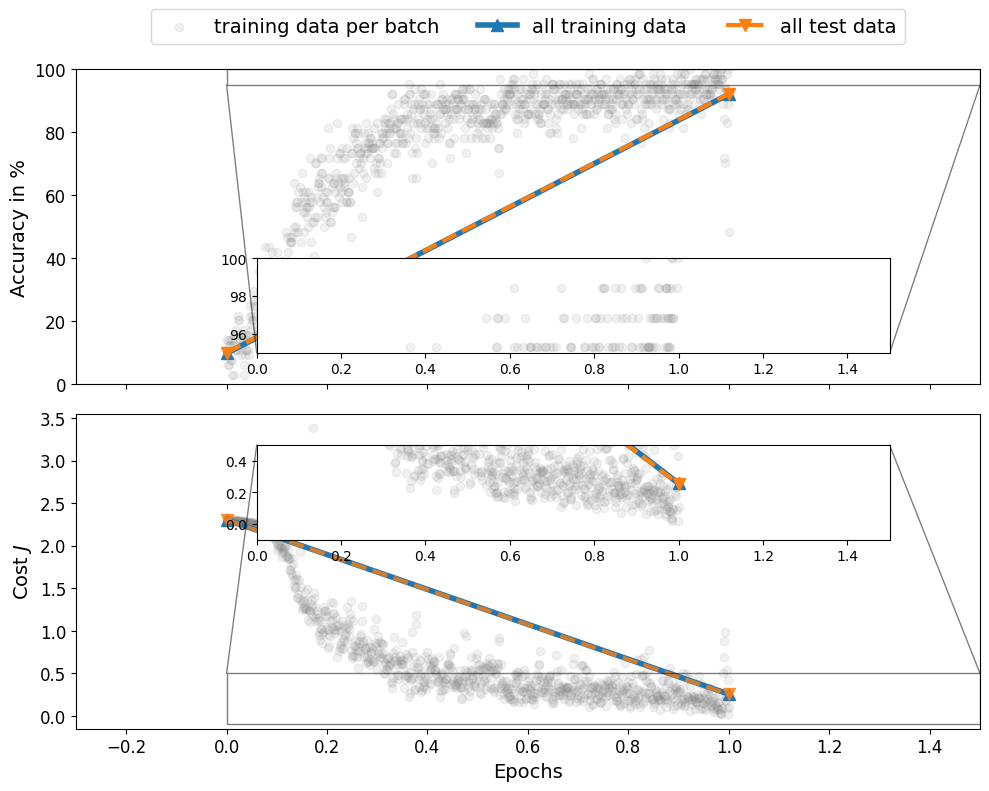

In [5]:
fig, axs, axins = mpf.plot_acc_cost(mynn.perflog2pandas(), len(mynn.dataloader_train))

## 1.2 Convolutional Neural Network

We build the following convolutional neural network:

| Layer | Function              | More detailed description                                | Output size | Number of parameters            |
|-------|-----------------------|----------------------------------------------------------|-------------|---------------------------------|
| 0     | Input                 | 28x28 px grey scale images                               | 1x28x28     | 0                               |
| 1     | Convolution           | 8 times 3x3x1 convolutions with stride 1 and padding 1   | 8x28x28     | (3\*3\*1+1)\*8 = 80      |
| 2     | ReLU                  | Non-linearity                                            | 8x28x28     | 0                               |
| 3     | Max Pooling           | 2x2 max pooling with stride 2                            | 8x14x14     | 0                               |
| 4     | Convolution           | 16 times 3x3x8 convolutions with stride 1 and padding 1  | 16x14x14    | (3\*3\*8+1\*16 = 1168   |
| 5     | ReLU                  | Non-linearity                                            | 16x14x14    | 0                               |
| 6     | Max Pooling           | 2x2 max pooling with stride 2                            | 16x7x7      | 0                               |
| 7     | Convolution           | 32 times 3x3x16 convolutions with stride 1 and padding 1 | 32x7x7      | (3\*3\*16+1\*32 = 4640  |
| 8     | ReLU                  | Non-linearity                                            | 32x7x7      | 0                               |
| 9     | Fully Connected       | 10 fully connected layer                                 | 10          | (32\*7\*7+1)\*10 = 15690 |
| 10    | Softmax               | Softmax layer                                            | 10          | 0                               |
| 11    | Classification Output | Crossentropy with 10 classes                             | 1           | 0                               |

The number of learnable parameters of the convolutional and fully connected layers can be computed as follows:
1. For a 3x3 convolution with stride 1 and padding 1 the lateral size of the images does not change. A single 3x3 convolution has 3\*3+1 learnable parameters (the weights of each pixel plus an additional bias). If we carry out $m$ of those in one layer, the number of weights becomes (3\*3+1)\*$m$. And if the input data to the layer was of dimension $l$ images, the number of parameters becomes (3\*3*$l$+1)\*$m$. This is the formula we have used to compute the number of learnable parameters.
2. A fully connected layer has ($n$+1)\*$m$ weights, where $n$ is the number of inputs and $m$ the number of outputs.

Adding the number of learnable parameters in the table, we find for the convolutional neural network we have built here a total of 80 + 1168 + 4640 + 15690 = 21578 learnable parameters. This is in contrast to the total number of weights in our fully connected network:

(28\*28+1)\*98 + (98+1)\*98 + (98+1)\*10 + (10+1)\*10 = 87732

We see that the convolutional network has only about one quarter of the number of parameters of the fully connected network, yet we observe better performance as we will see below.

In [16]:
import ex12_convnn_pytorch as cnnp
fname = cnnp.params2fname(nepochs, lr_sgd, batch_size_train, )
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    dataloader_train, dataloader_test = dh.init_MNIST(batch_size_train, batch_size_test)
    model = cnnp.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(cnnp.params2fname(nepochs, lr_sgd, batch_size_train))

Here we plot the performance data of the convolutional network. We see that it reaches above 98% accuracy after about 2 epochs.

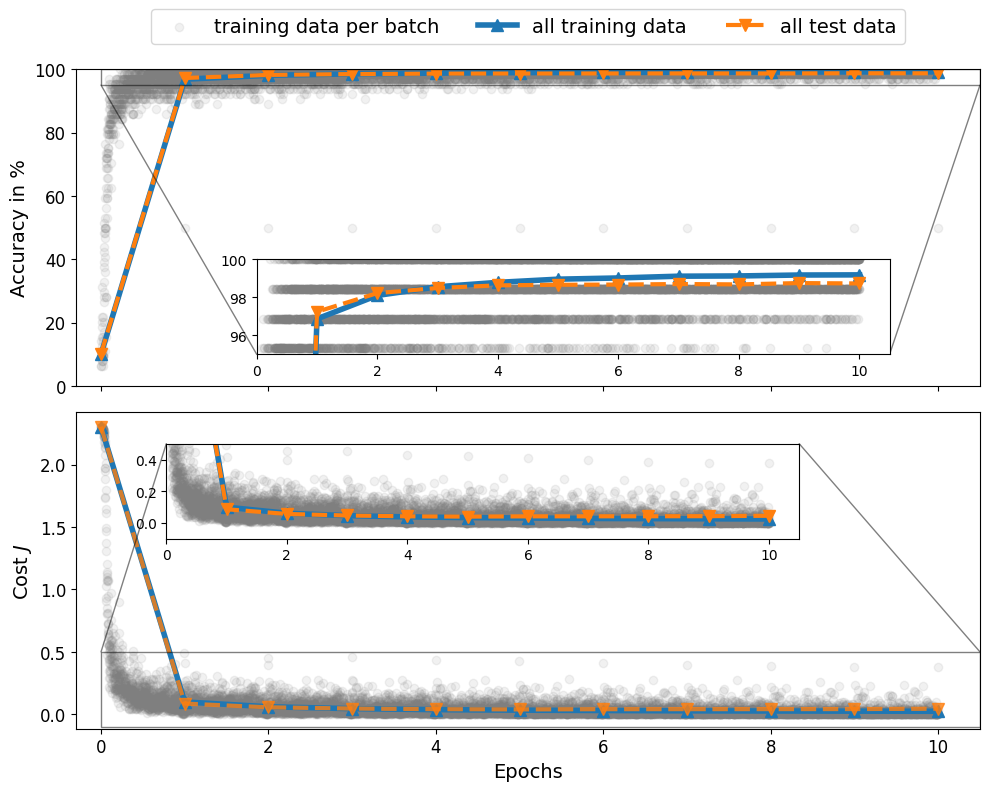

In [23]:
fig, axs, axins = mpf.plot_acc_cost(mynn.log2pandas(), len(mynn.dataloader_train))

The final accuracy of our convolutional network on the test data after 10 epochs is 98.7 % with a value of the cost function of 0.045. This performance is somewhat smaller than the performance of the network on the training data, which suggets, that we might have a slight overfitting of the data.

In [25]:
mynn.print_epoch_info()

!!!!!!!!!!!!!!!!!!!!!!!!!
!        TRAIN          !
!!!!!!!!!!!!!!!!!!!!!!!!!
! EPOCH:             10
! ITERATION:       9380
! COST:           0.024
! ACCURACY:       99.2%
!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!
!        TEST           !
!!!!!!!!!!!!!!!!!!!!!!!!!
! EPOCH:             10
! ITERATION:       9380
! COST:           0.045
! ACCURACY:       98.7%
!!!!!!!!!!!!!!!!!!!!!!!!!



## 1.3 Convolutional Neural Network